In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.17.0
GPU detected: []


In [ ]:
data = pd.read_csv("/content/Pahsto_NER.csv", encoding="utf-8")
data = data.fillna(method="ffill")
data.head(20)

print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

tags = list(set(data["Tag"].values))
num_tags = len(tags)

import plotly.express as px

fig = px.histogram(data[~data.Tag.str.contains("O")], x="Tag",color="Tag")
fig.show()

<ipython-input-2-1d3edfce6b0e>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill")


Unique words in corpus: 9913
Unique tags in corpus: 11


In [ ]:
fig.show()

In [ ]:
data.head(20)

Sentence #      Word             Tag
0          1.0         د               O
1          2.0  بلوچستان         B-PLACE
2          3.0    ايالتي  B-ORGANIZATION
3          4.0     حکومت  I-ORGANIZATION
4          5.0        او               O
5          6.0    امنيتي  B-ORGANIZATION
6          7.0     ادارو  I-ORGANIZATION
7          8.0         د               O
8          9.0       چمن         B-PLACE
9         10.0      پرلت               O
10        11.0     مشران               O
11        12.0     نيولې               O
12        13.0        دي               O
13        14.0        او               O
14        15.0    احتجاج               O
15        16.0    کوونکو               O
16        17.0        له               O
17        18.0       خوا               O
18        19.0       يوه               O
19        20.0     مياشت               O

In [ ]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 9913
Unique tags in corpus: 11


In [ ]:
import tqdm
def sentence_integrate(data):
  agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
  return data.groupby('Sentence #').apply(agg_func).tolist()

sentences=sentence_integrate(data)

sentences[0]

<ipython-input-6-56329ed9050e>:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



[('د', 'O')]

In [ ]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

word2idx
tag2idx

{'B-TIME': 0,
 'O': 1,
 'B-DATE': 2,
 'B-ORGANIZATION': 3,
 'I-ORGANIZATION': 4,
 'B-PERSON': 5,
 'I-PLACE': 6,
 'I-PERSON': 7,
 'B-PLACE': 8,
 'I-DATE': 9,
 'I-TIME': 10}

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 1

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [ ]:
#split into test and train
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#build model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import InputLayer, TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow import keras

model = keras.Sequential()
model.add(InputLayer((50,)))
model.add(Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len))
model.add(SpatialDropout1D(0.1))
model.add( Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))

#model summary
model.summary()

#show model plot
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='LR', expand_nested=True, dpi=300,
)

#compile model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 1)               │           9,914 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 50, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 200)             │          81,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,514 (357.48 KB)

 Trainable params: 91,514 (357.48 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

#%%time
logdir="log/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
chkpt = ModelCheckpoint("model_weights.weights.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)
callbacks = [PlotLossesCallback(), chkpt, early_stopping,tensorboard_callback]
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)
#Apply TensorBoard to check the detailed structure and performance
%load_ext tensorboard

%tensorboard --logdir log

In [ ]:
!pip install livelossplot

In [ ]:
!pip install livelossplot

In [ ]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss: {} ".format(results[0]))
print("test accuracy: {} ".format(results[1]))

Evaluate on test data
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8815 - loss: 0.8387
test loss: 0.8193073272705078 
test accuracy: 0.8850616216659546 


In [ ]:
i = np.random.randint(0, x_test.shape[0])
print("This is sentence:",i)
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_test[i], p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

This is sentence: 9845
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Word           True 	 Pred

------------------------------
غوښتنې         O	O


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=-1)

523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_classes.flatten()

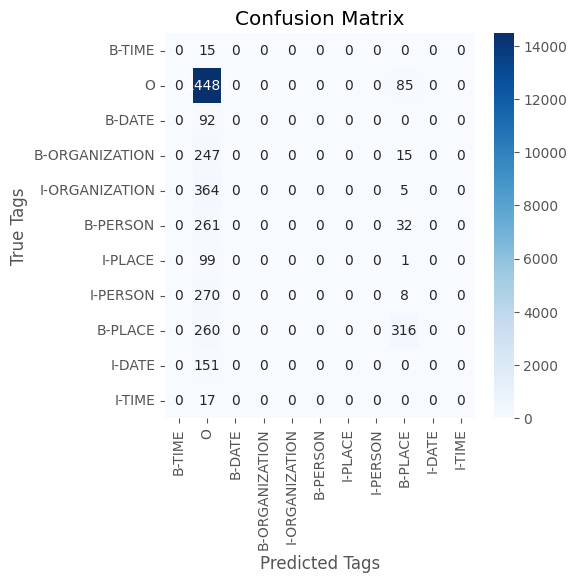

In [ ]:
cm = confusion_matrix(y_test_flat, y_pred_flat)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=tags, yticklabels=tags)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Tags')
plt.ylabel('True Tags')
plt.show()